# Particle filter demo: 2D rover position and velocity

This demo serves as demonstration on how to use the particle filter module shipped within
this repository. The notebook simulates a rover moving in 2D with constant-velocity dynamics and 
range measurements to fixed beacons. We will:

- Simulate a ground-truth trajectory and noisy range observations
- Build a simple constant-velocity Model compatible with `pygnss.filter`
- Run the particle filter and visualize position and velocity estimates

---

## Particle filters — brief introduction

Particle filters (also known as Sequential Monte Carlo methods) are a family of simulation-based algorithms that approximate the posterior distribution of a system's state by propagating and resampling a set of weighted samples (particles), enabling state estimation for strongly nonlinear or non‑Gaussian models.

### Intuition

Think of a particle filter like a crowd of guesses about the state you want to
estimate. In a positioning context, this state is usually the location where an object might be. Each guess
(a particle) is a complete possible state (for example: x, y, vx, vy). As the system moves and
we get measurements, we score each guess by how well it explains the measurements. We then
keep the better guesses, copy them (more often if they are good), and add a bit of random jitter
so the crowd explores nearby alternatives. Over time the crowd concentrates around the true state.

Why a Particle filter is helpful:

- Works when measurements or motion are complicated or noisy — the crowd can represent many possibilities.
- Can represent multiple plausible locations at once (not forced into a single average).

### Key differences vs EKF/UKF

- **Representation**: EKF/UKF approximate the posterior with a single Gaussian (mean + covariance).
  Particle Filters (PF) approximate the full posterior with many weighted samples and can model any
  arbitrary posterior distribution (if the particle sampling is good enough)
- **Linearity / Gaussian assumptions**: EKF linearizes the dynamics/measurements, while
  PF can handle highly non-linear models.
- **Computational cost**: EKF/UKF are generally cheaper ($O(n^3)$ for covariance operations 
  with state dimension n) whereas particle filters scale roughly 
  $O(N_{particles} \cdot cost_{particle})$ and can become expensive as the number 
  of particles or state dimension grows (though particle updates are easily parallelizable).
  This is the main drawback of PF against other filters such as e.g. EKF/UKF.
- **Degeneracy & resampling**: Particle filters can suffer sample impoverishment 
  (most of the weight concentrates on a few particles), so strategies must be put
  in place to focus effort on high‑weight particles while maintaining diversity 
  and preserving exploration.

### When to use particle filters

- Nonlinear, non-Gaussian problems where the posterior is far from Gaussian (e.g., multi-modal)
- For low-to-moderate state dimensions.

## Hands-on Particle Filter

In this notebook you will find a tutorial on the basics aspects of the PF
applied to a simple navigation problem and how these aspects are represented
in the `pygnss.filter.particle` module.

### Prerequisites

To run this notebook, make sure you have the following packages included in your
system

```text
matplotlib
numpy
pygnss
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pygnss

A Particle Filter (and in fact all estimation filters) require a `Model` that
informs how to **propagate** the state in time and how to **translate** the state
to the observations.

- `propage_state`: given a state at epoch $k$, generate the prior state for the next epoch $k+1$.
In a navigation context, it would consist in propagating the position based on the
knowledge of the previous position and velocity.
- `to_observations`: given a state, generate the observations. This is used to compute the residuals
relative to the actual observations, that will later lead to the innovation that
will be applied to the estimated state.

A `Model` interface is provided in the `pygnss.filter` module. We are going
to derive a constant-velocity 2D model with range observations to fixed beacons
(i.e. `ConstantVelocityRange2D`)

In [2]:
from pygnss.filter import Model, ModelObs

class ConstantVelocityRange2D(Model):

    def __init__(self, dt: float, beacons: np.ndarray):
        self.dt = float(dt)
        self.beacons = np.asarray(beacons, dtype=float)
        self._Phi = np.array([[1, 0, dt, 0],
                              [0, 1, 0, dt],
                              [0, 0, 1,  0],
                              [0, 0, 0,  1]], dtype=float)

    def propagate_state(self, state: np.ndarray) -> np.ndarray:
        return self._Phi @ state

    def to_observations(self, state: np.ndarray, compute_jacobian: bool = False, **kwargs) -> ModelObs:
        """
        Compute range measurements to beacons from the current state.
        """
        pos = state[:2]
        rho = pos - self.beacons
        ranges = np.sqrt(np.sum(rho**2, axis=1))
        H = None
        if compute_jacobian:
            dr_dpos = rho / ranges[:, np.newaxis]
            H = np.zeros((len(ranges), 4))
            H[:, :2] = dr_dpos
        return ModelObs(ranges, H)

    def Phi(self):
        return self._Phi

The Filter class also requires a class to handle the estimated state (i.e.
print to a file, make plots, ...)

In [3]:
from pygnss.filter import StateHandler

class HistoryHandler(StateHandler):
    def __init__(self):
        self.states = []
        self.postfits = []

    def process_state(self, state: np.ndarray, covariance_matrix: np.ndarray, **kwargs):
        self.states.append(np.array(state, dtype=float).copy())
        if 'postfits' in kwargs and kwargs['postfits'] is not None:
            self.postfits.append(np.array(kwargs['postfits'], dtype=float).copy())

## Scenario

To demonstrate the application of the PF, we are going to simulate a 2D
navigation case. The following code snippet simulates a trajectory as well
as some noise ranges (i.e. distances between the rover and each of the beacons).
The ranges will be the measurements to be ingested by the PF to estimate the
position

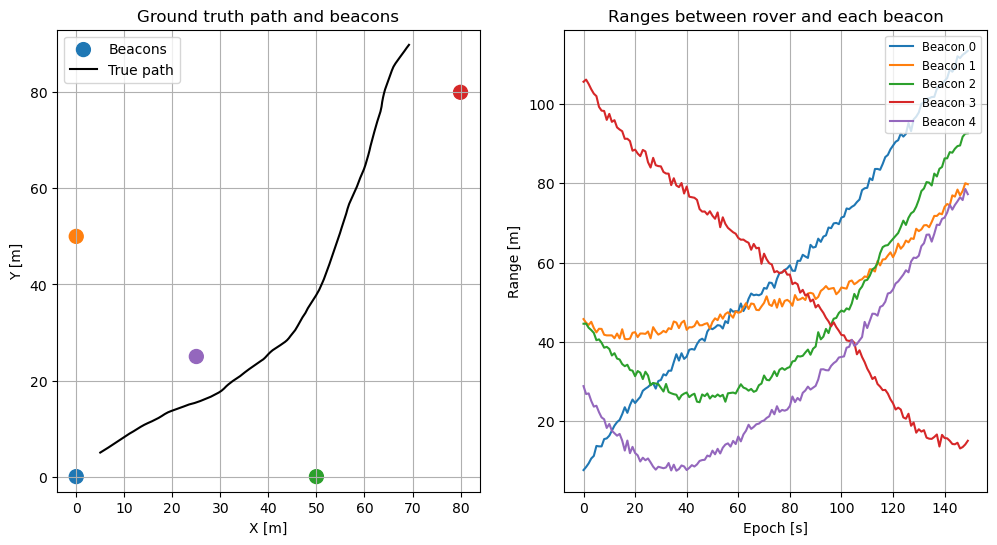

In [4]:
# Simulate ground-truth motion and noisy range measurements
np.random.seed(42)
dt = 1.0
steps = 150

# Beacons in 2D space (meters)
beacons = np.array([[0, 0], [0, 50], [50, 0], [80, 80], [25, 25]], dtype=float)

# True initial state [x, y, vx, vy]
x0_true = np.array([5.0, 5.0, 0.8, 0.5])

# Process (acceleration) and measurement noise
sigma_a = 0.05   # m/s^2
sigma_r = 0.8    # m range noise

# Constant-velocity model matrices
F = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1,  0],
              [0, 0, 0,  1]], dtype=float)
G = np.array([[0.5*dt**2, 0],
              [0, 0.5*dt**2],
              [dt, 0],
              [0, dt]], dtype=float)

# Simulate trajectory
x_true = np.zeros((steps, 4))
x_true[0] = x0_true
for k in range(1, steps):
    a = sigma_a * np.random.randn(2)
    x_true[k] = F @ x_true[k-1] + G @ a

def ranges_from_state(state):
    pos = state[:2]
    rho = pos - beacons
    return np.sqrt(np.sum(rho**2, axis=1))

# Generate noisy range measurements
ranges = np.zeros((steps, beacons.shape[0]))
for k in range(steps):
    ranges[k] = ranges_from_state(x_true[k]) + sigma_r * np.random.randn(beacons.shape[0])

# Visualize ground truth and beacons (use matching colors for ranges)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Get the default color cycle used by matplotlib so we can reuse the same colors
prop_cycle = plt.rcParams.get('axes.prop_cycle').by_key()
colors = prop_cycle.get('color', list(plt.cm.tab10.colors))
# If there are fewer colors than beacons, repeat the cycle to cover all beacons
if len(colors) < len(beacons):
    colors = (colors * ((len(beacons) // len(colors)) + 1))[:len(beacons)]
# Plot beacons using the same color assigned to each beacon's range series
ax1.scatter(beacons[:, 0], beacons[:, 1], c=colors[:len(beacons)], marker='o', s=100, label='Beacons')
ax1.plot(x_true[:, 0], x_true[:, 1], 'k-', label='True path')
ax1.axis('equal')
ax1.set_xlabel('X [m]')
ax1.set_ylabel('Y [m]')
ax1.grid(True)
ax1.legend()
ax1.set_title('Ground truth path and beacons')


# Visualize ranges (plot per-beacon and reuse same colors)
for i in range(ranges.shape[1]):
    ax2.plot(ranges[:, i], color=colors[i], label=f'Beacon {i}')
ax2.grid(True)
ax2.set_xlabel('Epoch [s]')
ax2.set_ylabel('Range [m]')
ax2.legend(loc='upper right', fontsize='small')
_ = ax2.set_title('Ranges between rover and each beacon')

plt.show()

## Filter setup 

In order to setup the filter, we will be requiring the following:

- A class that computes the weight for each sample, we will be using `WeightEstimatorGaussian`
which computes the weight of each particle based on the likelihood

In [5]:
from pygnss.filter.particle import WeightEstimatorGaussian

- An initial set of particles (candidates of possible positions). This will be
refined as measurements are processed

In [ ]:

# Initialize particle filter
N = 1000  # number of particles
x0_guess = np.array([2.0, 2.0, 0.0, 0.0])
P0_pos = 10.0  # meters std
P0_vel = 1.0   # m/s std

particles = []
for _ in range(N):
    s = x0_guess + np.array([
        P0_pos*np.random.randn(),
        P0_pos*np.random.randn(),
        P0_vel*np.random.randn(),
        P0_vel*np.random.randn(),
    ])
    particles.append(s)


In [ ]:
# Set up the particle filter components: the model, weight estimator, and state handler
model = ConstantVelocityRange2D(dt=dt, beacons=beacons)
weight_estimator = WeightEstimatorGaussian()
handler = HistoryHandler()

# The roughening is a process to add some noise to the particles after resampling to maintain diversity
# we are adding a noise with standard deviation sigma_r to each state dimension
# (the sigma_r defined earlier for measurement noise is a reasonable choice here)
roughening = [sigma_r, sigma_r, sigma_r, sigma_r]

Once the different components are defined, we are now in the position of instantiating the filter

In [18]:
from pygnss.filter.particle import Filter

pf = Filter(
    initial_states=particles,
    weight_estimator=weight_estimator,
    model=model,
    state_handler=handler,
    roughening_std=roughening,
)

R = (sigma_r**2) * np.eye(beacons.shape[0])
print('PF initialized with', len(particles), 'particles')

PF initialized with 1000 particles


Finally, the measurements can be processed sequentially

In [13]:
for k in range(steps):
    yk = ranges[k]
    pf.process(yk, R)

Under the hood, while the measurements are processed and estimates obtained, they
are forwarded into the `handler` class defined above. You can access the final
estimates with the following command:

In [14]:
estimates = np.array(handler.states)

And the plots of position and errors can be obtained as well

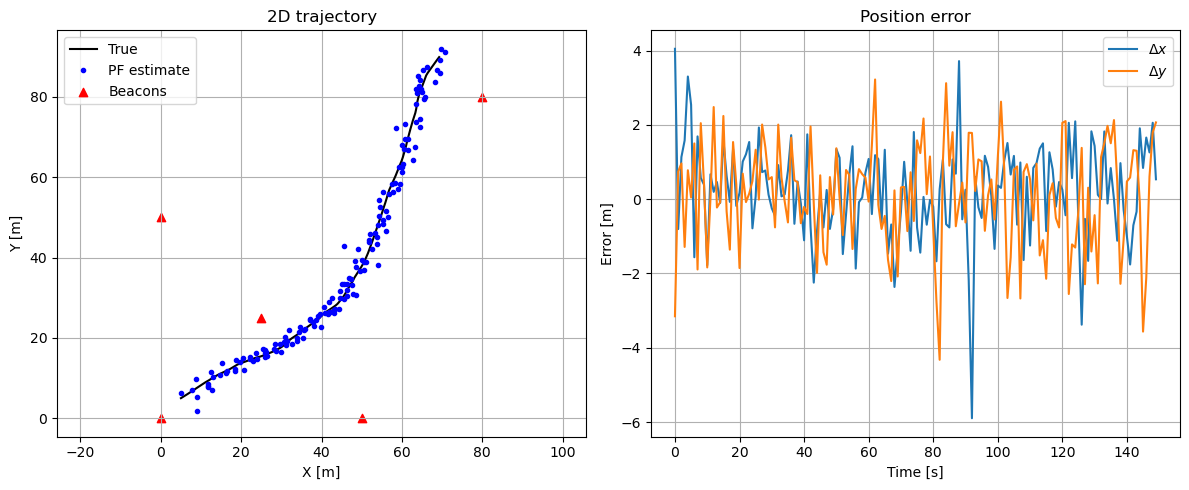

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(x_true[:, 0], x_true[:, 1], 'k-', label='True')
axs[0].plot(estimates[:, 0], estimates[:, 1], 'b.', label='PF estimate')
axs[0].scatter(beacons[:, 0], beacons[:, 1], c='red', marker='^', label='Beacons')
axs[0].set_title('2D trajectory')
axs[0].set_xlabel('X [m]')
axs[0].set_ylabel('Y [m]')
axs[0].axis('equal')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(estimates[:, 0] - x_true[:, 0], label='$\Delta x$')
axs[1].plot(estimates[:, 1] - x_true[:, 1], label='$\Delta y$')
axs[1].set_title('Position error')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Error [m]')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()

Also, some basic performance metrics can be obtained since we know the actual position

In [16]:
pos_err = np.linalg.norm(estimates[:, :2] - x_true[:, :2], axis=1)
vel_err = np.linalg.norm(estimates[:, 2:] - x_true[:, 2:], axis=1)
print(f'Position RMSE: {np.sqrt(np.mean(pos_err**2)):.3f} m')
print(f'Velocity RMSE: {np.sqrt(np.mean(vel_err**2)):.3f} m/s')

Position RMSE: 1.922 m
Velocity RMSE: 1.680 m/s


An additional quality metrics to evaluate the performance of the filter are
the `postfit` residuals, which give information on the errors that could not be
absorbed by the estimated parameters. In this simulation, these errors correspond
to Additive White Gaussian Noise (AWGN), therefore, the `postfit` residuals
should be distributed via a Gaussian function with zero mean and `sigma_r` 
standard deviation.

Postfit Mean: 0.036 m
Postfit Std:  1.373 m


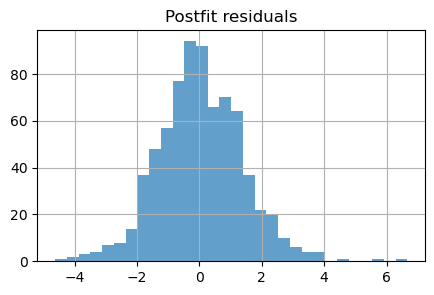

In [19]:
postfits = np.array(handler.postfits).flatten()

plt.figure(figsize=(5, 3))
plt.hist(postfits, bins=30, alpha=0.7)
plt.title('Postfit residuals')
plt.grid(True)

print(f'Postfit Mean: {np.mean(postfits):.3f} m')
print(f'Postfit Std:  {np.std(postfits):.3f} m')

## Conclusions

This notebook demonstrates a working particle filter for a 2D constant-velocity rover using range
measurements to fixed beacons. The example is intentionally simple but highlights the main pieces
required to run a particle filter: model propagation, an observation mapping, weight computation,
resampling, and a state handler to record results.

Key takeaways:

- The particle filter converges from a relatively coarse prior and is able to track both position
  and velocity of the rover over time when supplied with per-epoch range measurements.
- Postfit residuals (stored in the handler) are useful to check consistency: in this setup they are
  approximately zero-mean and their spread is comparable to the measurement noise specified by
  `sigma_r` (see the histogram and printed statistics above).

Practical notes and next steps:

- Increase or decrease `N` (number of particles) to explore the accuracy vs computational cost trade-off.
- Try alternative resampling schemes, adjust the `roughening_std`, or use informed proposal distributions
  to mitigate sample impoverishment in long runs.
- Extend the model to include sensor biases, additional measurement types (e.g., bearings), or 3D motion
  for more realistic scenarios.
- Add automated tests that exercise the filter on known trajectories to track regressions when changing
  the implementation.

Reproducibility:

- To reproduce the figures and metrics in this notebook, run the cells top-to-bottom. Key parameters
  to try are `N` (particles), `sigma_r` (measurement noise), beacon positions (`beacons`), and the
  `roughening_std` used after resampling.

## Further reading

- Elfring, Jos, Elena Torta, and René Van De Molengraft. "[Particle filters: A hands-on tutorial.](https://pmc.ncbi.nlm.nih.gov/articles/PMC7826670/pdf/sensors-21-00438.pdf)" Sensors 21, no. 2 (2021): 438.
